# 1) Import libraries

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix, roc_curve



%matplotlib inline

# 2) Read files

In [36]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# 3) Exploration

###  3-1) visualizing the distribution of the nine variables in the dataset. We can do this by plotting a histogram

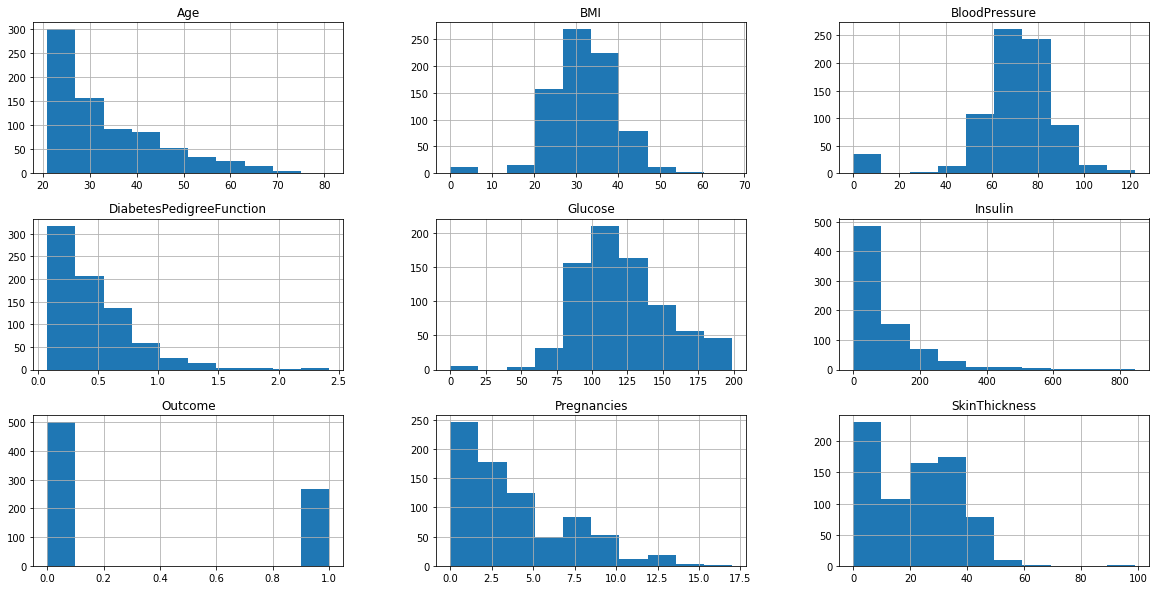

In [4]:
plt.rcParams["figure.figsize"] = (20,10)
df.hist()
plt.show()

#### The histogram provides some interesting insights into the data. From the histogram for Age, we can see that most of the data was collected from young people, with the most common age group between 20-30 years old. We can also see that the distribution for BMI,BloodPressure, and Glucose concentration is normally distributed (that is, a bell curve shape), which is what we we expect when we collect such statistics from a population.However, note that the tail of the Glucose concentration distribution shows some rather extreme values. It appears that there are people with plasma Glucose concentration that is almost 200. On the opposite end of the distribution, we can see that there are people with 0values for BMI, BloodPressure, and Glucose. 
#### If we look at the distribution for the number of previous Pregnancies, we can see some outliers as well. We can see that some patients had more than 15 previous pregnancies. While that may not be entirely surprising, we should keep such outliers in mind when we do our analysis, as it can skew our results.
#### The distribution of outcome shows that approximately 65% of the population belongs to class 0 (no diabetes), while the remaining 35% belongs to class 1 (diabetes).

### 3-2) visualize the difference in distribution between diabetics and non-diabetics

C:\Users\walid\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\walid\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\walid\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\walid\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

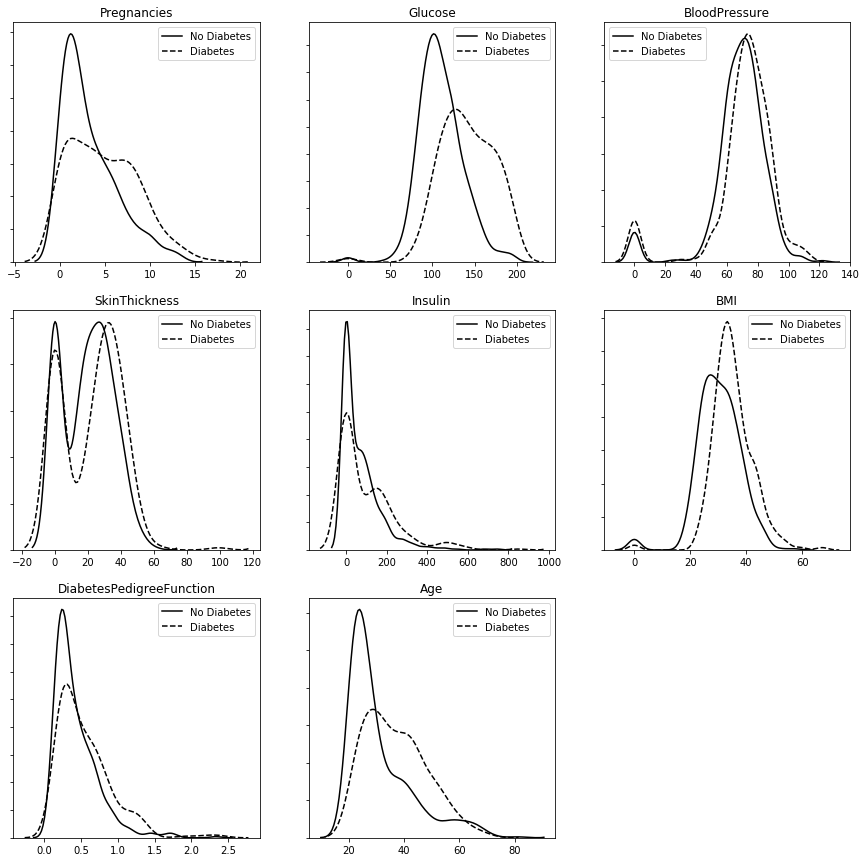

In [5]:
# Create a subplot of 3*3
plt.subplots(3,3,figsize=(15,15))

# Plot a density plot for each variable
for idx, col in enumerate(df.columns):
    ax = plt.subplot(3,3,idx+1)
    ax.yaxis.set_ticklabels([])
    sns.distplot(df.loc[df.Outcome == 0][col], hist=False, axlabel= False,
               kde_kws={'linestyle':'-', 'color':'black', 'label':'No Diabetes'})
    sns.distplot(df.loc[df.Outcome == 1][col], hist=False, axlabel= False,
               kde_kws={'linestyle':'--', 'color':'black', 'label':'Diabetes'})
    ax.set_title(col)

# Hide the 9th subplot (bottom right) since there are only 8 plots
plt.subplot(3,3,9).set_visible(False)

plt.show()


#### The preceding density plots look complicated, but let's focus on each individual plot and see what insights can we gain. If we look at the plot for the Glucose variable, we can see that among the non-diabetics (solid line), the curve has a normal distribution centered around the value 100. This tells us that among non-diabetics, most people have a blood glucose value of 100 mg/dL. On the other hand, if we look at the Diabetics (dashed line),the curve is wider and is centered around a value of 150. This tells us that diabetics tends to have a wider range of blood glucose value, and the average blood glucose value is around150 mg/dL. Therefore, there is a significant difference in blood glucose values for diabetes vs non-diabetics.  A similar analysis can also be made for the variable BMI and Age. In other words, the Glucose, BMI, and Age variables are strong predictors for diabetes. People with diabetes tend to have higher blood glucose level, higher BMI, and are older.
#### On the other hand, we can see that for variables such as BloodPressure andSkin Thickness, there is no significant difference in the distribution between diabetics and non-diabetics. The two groups of people tend to have similar blood pressure and skinthickness values. Therefore, BloodPressure and Skin Thickness are poorer predictors for diabetes.

# 4) Data Preprocessing 

In [7]:
print(df.isnull().any())

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool


In [8]:
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

#### We can see that there are 768 rows of data, and the Pregnancies, Glucose,BloodPressure, SkinThickness, Insulin, and BMI columns have a minimum value of0. This doesn't quite make sense. The measurements for Glucose, BloodPressure,SkinThickness, Insulin, and BMI should never be 0. This is an indication that there aremissing values in our dataset. The values were probably recorded as 0 due to certain issuesduring data collection. Perhaps the equipment was faulty, or the patient was unwilling tohave their measurements taken

In [9]:
print('Number of rows with 0 values for each variable')
for col in df.columns:
    missing_rows = df.loc[df[col] == 0].shape[0]
    print(col +' : '+str(missing_rows))

Number of rows with 0 values for each variable
Pregnancies : 111
Glucose : 5
BloodPressure : 35
SkinThickness : 227
Insulin : 374
BMI : 11
DiabetesPedigreeFunction : 0
Age : 0
Outcome : 500


#### In the Insulin column, there are 374 rows with 0 values. That is almost half of the datathat we have! Clearly, we cannot discard these rows with 0 values as that will cause asignificant drop in model performance.

In [37]:
#let's replace the 0 values in the Glucose, BloodPressure, SkinThickness,Insulin, and BMI columns with NaN.
df['Glucose'] = df['Glucose'].replace(0,np.nan)
df['BloodPressure'] = df['BloodPressure'].replace(0,np.nan)
df['SkinThickness'] = df['SkinThickness'].replace(0,np.nan)
df['Insulin'] = df['Insulin'].replace(0,np.nan)
df['BMI'] = df['BMI'].replace(0,np.nan)

In [11]:
for col in df.columns:
    missings = df.loc[df[col] == 0].shape[0]
    print(col +' : '+ str(missings))

Pregnancies : 111
Glucose : 0
BloodPressure : 0
SkinThickness : 0
Insulin : 0
BMI : 0
DiabetesPedigreeFunction : 0
Age : 0
Outcome : 500


In [12]:
#Now, let's replace the NaN values with the mean of
#the non-missing values. We can do thisusing the handy fillna() function in pandas
df['Glucose'] = df['Glucose'].fillna(df['Glucose'].mean())
df['BloodPressure'] = df['BloodPressure'].fillna(df['BloodPressure'].mean())
df['SkinThickness'] = df['SkinThickness'].fillna(df['SkinThickness'].mean())
df['Insulin'] = df['Insulin'].fillna(df['Insulin'].mean())
df['BMI'] = df['BMI'].fillna(df['BMI'].mean())

### 4-1) Data standardization

In [13]:
# To standardize our data, we can use the preprocessing class from scikit-learn
df_scaled = preprocessing.scale(df)

C:\Users\walid\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [14]:
# Since the object returned by the preprocessing.scale() function is no longer a pandasDataFrame, let's convert it back
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

In [15]:
df_scaled['Outcome'] = df['Outcome']
df = df_scaled

In [16]:
print(df.describe().loc[['mean', 'std','max'],].round(2).abs())

      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
mean         0.00     0.00            0.0           0.00     0.00  0.00   
std          1.00     1.00            1.0           1.00     1.00  1.00   
max          3.91     2.54            4.1           7.95     8.13  5.04   

      DiabetesPedigreeFunction   Age  Outcome  
mean                      0.00  0.00     0.35  
std                       1.00  1.00     0.48  
max                       5.88  4.06     1.00  


### 4-2) Splitting the data into training, testing, and validation sets

In [17]:
x = df.loc[:, df.columns != 'Outcome']
y = df.loc[:,'Outcome']

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [19]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

# 5) Model building

In [20]:
model = Sequential()

In [21]:
model.add(Dense(32, activation='relu', input_dim=8))
model.add(Dense(16, activation='relu'))

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
model.add(Dense(1,activation='sigmoid'))

In [23]:
model.compile(optimizer='adam',   
              loss='binary_crossentropy',    
              metrics=['accuracy'])

In [24]:
model.fit(x_train, y_train, epochs=200)

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
491/491 [==============================] - 1s 3ms/step - loss: 0.6947 - accuracy: 0.5275
Epoch 2/200
491/491 [==============================] - 0s 35us/step - loss: 0.6121 - accuracy: 0.7210
Epoch 3/200
491/491 [==============================] - 0s 37us/step - loss: 0.5625 - accuracy: 0.7597
Epoch 4/200
491/491 [==============================] - 0s 39us/step - loss: 0.5263 - accuracy: 0.7658
Epoch 5/200
491/491 [==============================] - 0s 33us/step - loss: 0.5013 - accuracy: 0.7637
Epoch 6/200
491/491 [==============================] - 0s 33us/step - loss: 0.4852 - accuracy: 0.7739
Epoch 7/200
491/491 [==============================] - 0s 35us/step - loss: 0.4722 - accuracy: 0.7760
Epoch 8/200
491/491 [==============================] - 0s 33us/step - loss: 0.4650 - accuracy: 0.7699
Epoch 9/200
491/491 [==============================] - 0s 35us/step - loss: 0.4596 - accuracy: 0.7699
Epoch 10/200
491/491 [=============

491/491 [==============================] - 0s 37us/step - loss: 0.2278 - accuracy: 0.9043
Epoch 158/200
491/491 [==============================] - 0s 33us/step - loss: 0.2267 - accuracy: 0.9043
Epoch 159/200
491/491 [==============================] - 0s 35us/step - loss: 0.2257 - accuracy: 0.9084
Epoch 160/200
491/491 [==============================] - 0s 45us/step - loss: 0.2243 - accuracy: 0.9002
Epoch 161/200
491/491 [==============================] - 0s 37us/step - loss: 0.2238 - accuracy: 0.9022
Epoch 162/200
491/491 [==============================] - 0s 35us/step - loss: 0.2229 - accuracy: 0.9022
Epoch 163/200
491/491 [==============================] - 0s 35us/step - loss: 0.2235 - accuracy: 0.9043
Epoch 164/200
491/491 [==============================] - 0s 33us/step - loss: 0.2219 - accuracy: 0.9084
Epoch 165/200
491/491 [==============================] - 0s 33us/step - loss: 0.2248 - accuracy: 0.8900
Epoch 166/200
491/491 [==============================] - 0s 35us/step - loss: 

In [25]:
scores = model.evaluate(x_train,y_train)
print("Training Accuracy : %.2f%% \n"%(scores[1]*100))
scores = model.evaluate(x_test,y_test)
print("Testing Accuracy : %.2f%% \n"%(scores[1]*100))

491/491 [==============================] - 0s 459us/step
Training Accuracy : 93.08% 

154/154 [==============================] - 0s 19us/step
Testing Accuracy : 76.62% 



#### The accuracy is 93.08% and 76.62% on the training set and testing set respectively. The difference in accuracy between the training and testing set isn't surprising since the model was trained on the training set. In fact, by training the model over more iterations, we canachieve 100% accuracy on the training set, but that would not be desirable as it just means that we are overfitting our model. The testing accuracy should always be used to evaluate the real-world performance of our model, as the testing set represents real-world data thatthe model has never seen before

# 6) Confusion Matrix

Text(114.0, 0.5, 'Actual')

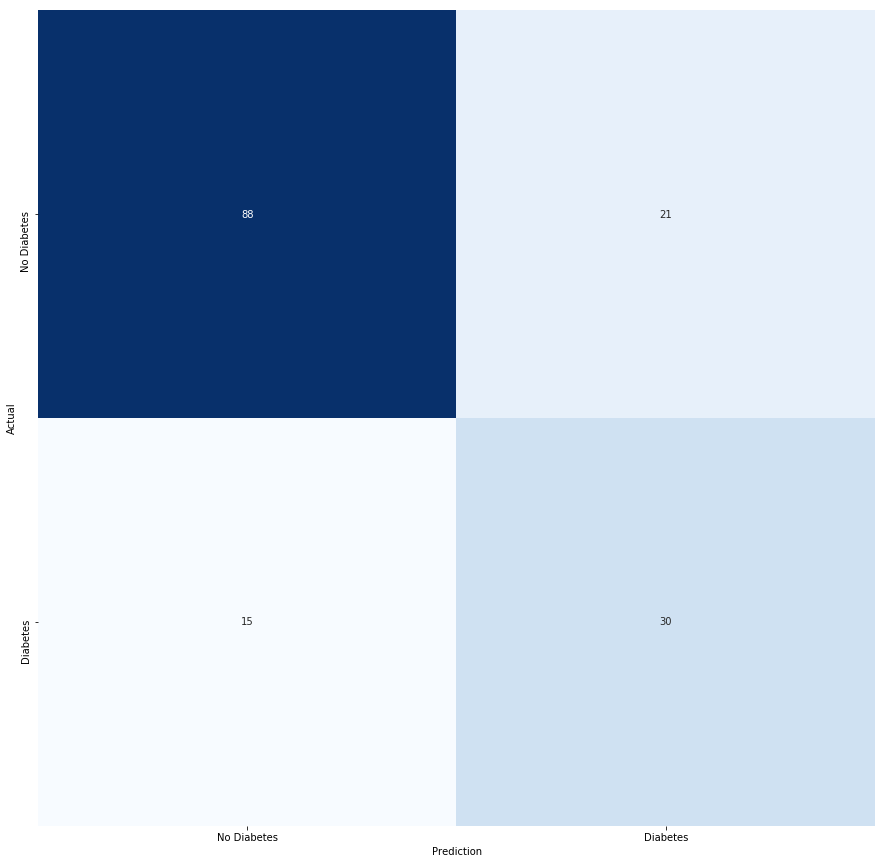

In [30]:
plt.figure(figsize=(15,15))
y_test_pred = model.predict_classes(x_test)
c_matrix = confusion_matrix(y_test, y_test_pred)
ax = sns.heatmap(c_matrix, annot=True,
                 xticklabels=['No Diabetes','Diabetes'],
                 yticklabels=['No Diabetes','Diabetes'], 
                 cbar=False, cmap='Blues')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')

#### From the preceding confusion matrix, we can see that most predictions are true negativesand true positives (as indicated by the 76.62% test accuracy in the previous section). Theremaining 15 predictions are false negatives and 21 other predictions are false positives,which are undesirable.
#### For diabetes prediction, a false negative is perhaps more damaging than a false positive. A false negative means telling the patient that they will not develop diabetes within the nextfive years, when in fact they would. Therefore, when we evaluate the performance of different models for predicting the onset of diabetes, a model with a lower false negative is more desirable

# 7) ROC curve

### The ROC curve is a plot with the True Positive Rate (TPR) on the y axis and the False Positive Rate (FPR) on the x axis.

##### When we analyze the ROC curve, we look at the area under the curve (AUC) to evaluate the performance of the model that produced the curve. A large AUC indicates that themodel is able to differentiate the respective classes with high accuracy, while a low AUC indicates that the model makes poor, often wrong predictions. A ROC curve that lies on the diagonal indicates that the model does no better than random

In [32]:
y_test_pred_probs = model.predict(x_test)

In [33]:
FPR, TPR, _ = roc_curve(y_test, y_test_pred_probs)

Text(0, 0.5, 'True Positive Rate')

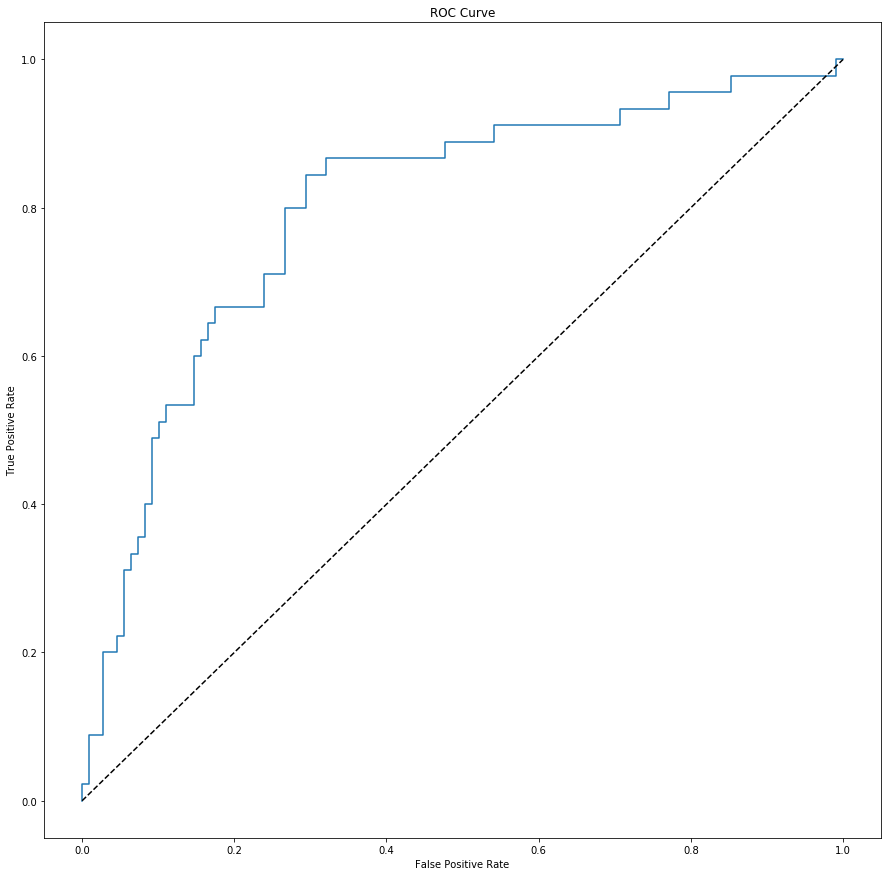

In [35]:
plt.figure(figsize=(15,15))
plt.plot(FPR, TPR)
plt.plot([0,1],[0,1],'--', color='black') #diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#### From the preceding ROC Curve, we can see that the model performs rather well, close to the model ROC Curve shown in the preceding diagram. This shows that our model is able to differentiate samples of different classes, making good predictions.